# RL - Exercício 3 - Desafio Mountain Car (Opcional)

## Trabalho desenvolvido durante o MBA em Data Science / IA na FIAP - 2022~2023.

## Prof. Felipe Teodoro

## Agente de Reinforcement Learning jogando Montain Car usando Q-Learning

<img src="https://www.gymlibrary.dev/_images/mountain_car.gif" alt="Environments"/>

### 🎮 Environments:

- [Mountain Car](https://www.gymlibrary.dev/environments/classic_control/mountain_car/)


### 📚 RL-Library:

- Python and NumPy
- [Gym](https://www.gymlibrary.dev/)

## Instalar dependências e criar um display virtual 🔽


In [1]:
!pip install gym==0.24
!pip install pygame
!pip install numpy

!pip install huggingface_hub
!pip install pickle5
!pip install pyyaml==6.0
!pip install imageio
!pip install imageio_ffmpeg
!pip install pyglet==1.5.1
!pip install tqdm

In [2]:
%%capture
!apt update
!apt install ffmpeg xvfb
!pip install xvfbwrapper
!pip install pyvirtualdisplay

Para garantir que as novas bibliotecas instaladas sejam usadas, **às vezes é necessário reiniciar o tempo de execução do notebook**. A próxima célula forçará o **tempo de execução a travar, então você precisará se conectar novamente e executar o código a partir daqui**.

In [3]:
# import os
# os.kill(os.getpid(), 9)

In [4]:
# Virtual display
from pyvirtualdisplay import Display

virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

## Importação de pacotes 📦

Além das bibliotecas instaladas, utilizamos também:

- `random`: Para gerar números aleatórios (que serão úteis para a política epsilon-greedy).
- `imageio`: Para gerar um vídeo de replay.

In [5]:
import numpy as np
import gym
import random
import imageio
import os
import tqdm
import matplotlib.pyplot as plt
import math

# import pickle5 as pickle
from tqdm.notebook import tqdm

In [6]:
random.seed(73)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
env = gym.make('MountainCar-v0')

### Verifique o Environment:


In [8]:
print("_____OBSERVATION SPACE_____ \n")
print("Observation Space", env.observation_space)
print("Sample observation", env.observation_space.sample()) # Get a random observation

_____OBSERVATION SPACE_____ 

Observation Space Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Sample observation [-0.6760119   0.04352124]


In [9]:
print("\n _____ACTION SPACE_____ \n")
print("Action Space Shape", env.action_space.n)
print("Action Space Sample", env.action_space.sample()) # Take a random action


 _____ACTION SPACE_____ 

Action Space Shape 3
Action Space Sample 2


In [10]:
state_space = env.observation_space
print("There are ", state_space, " possible states")

action_space = env.action_space.n
print("There are ", action_space, " possible actions")

There are  Box([-1.2  -0.07], [0.6  0.07], (2,), float32)  possible states
There are  3  possible actions


Estudando melhor o espaço de Observação temos a seguinte descrição do Enviroment:

Given an action, the mountain car follows the following transition dynamics:

velocityt+1 = velocityt + (action - 1) * force - cos(3 * positiont) * gravity

positiont+1 = positiont + velocityt+1

where force = 0.001 and gravity = 0.0025. The collisions at either end are inelastic with the velocity set to 0 upon collision with the wall. The position is clipped to the range [-1.2, 0.6] and velocity is clipped to the range [-0.07, 0.07].


In [11]:
min_v = env.observation_space.low
print("Min possible values ", min_v)

Min possible values  [-1.2  -0.07]


In [12]:
max_v = env.observation_space.high
print("Max possible values ", max_v)

Max possible values  [0.6  0.07]


In [13]:
state = env.reset()

In [14]:
env.step(env.action_space.sample())
img = env.render(mode='rgb_array')

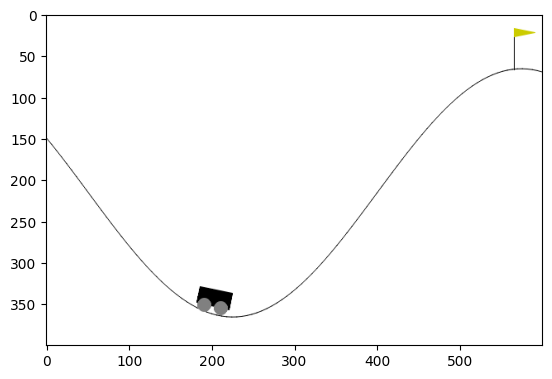

In [15]:
plt.imshow(img)

## O Grande desafio deste notebook é pensar em uma forma de discretizar a velocidade e a posição do carrinho em estados para criar a nossa Q-Table


In [16]:
state_space = env.observation_space

# Posições e velocidades máximas e mínimas
pos_min = state_space.low[0]
pos_max = state_space.high[0]
vel_min = state_space.low[1]
vel_max = state_space.high[1]

# Separar posição e velocidade em intervalos
pos_int = 20  # Número de intervalos para a posição
vel_int = 15  # Número de intervalos para a velocidade

# Separação em um espaço linear tanto da posição como da velocidade
pos_sp_lin = np.linspace(pos_min, pos_max, pos_int)
vel_sp_lin = np.linspace(vel_min, vel_max, vel_int)

# Função para mapear: estado do ambiente -> estado discreto correspondente
def mapear_obs(observation):
  pos_disc = np.digitize(observation[0], pos_sp_lin)
  vel_disc = np.digitize(observation[1], vel_sp_lin)
  if pos_disc <= 0:
    pos_disc = 0
  if pos_disc >= pos_sp_lin.shape[0] - 1:
    pos_disc = pos_sp_lin.shape[0] - 1
  if vel_disc <= 0:
    vel_disc = 0
  if vel_disc >= vel_sp_lin.shape[0] - 1:
    vel_disc = vel_sp_lin.shape[0] - 1

  return pos_disc, vel_disc

In [17]:
# Inicialização da Q-table com as dimensões corretas
# Temos três variáveis para representar os estados:
#   Posição discretizada
#   Velocidade discretizada
#   Ação que o agente pode tomar
# Desta forma, a Q-Table será tridimencional

Qtable_mountain_car = np.zeros((pos_int, vel_int, env.action_space.n))

In [18]:
Qtable_mountain_car.shape

(20, 15, 3)

## Definir funções de política de exploração

Exploração curiosa e gananciosa

In [19]:
def epsilon_greedy_policy(Q, state, epsilon):
  if random.uniform(0, 1) < epsilon:
    # Ação aleatória (exploração curiosa)
    return random.randint(0, Q.shape[-1] - 1)
  else:
    # Ação com base nos valores Q (exploração gananciosa)
    return greedy_policy(Q, state)

def greedy_policy(Q, state):
  pos_disc, vel_disc = mapear_obs(state)
  return np.argmax(Q[pos_disc, vel_disc])

## Parâmetros de Treinamento

In [20]:
# Parâmetros de treinamento
#   Quantidade de vezes que o agente em treinamento deve convergir para solução
#   antes de parar o treinamento
min_conv_count = 1500

learning_rate = 0.25 # Taxa de aprendizado

# Parâmetros do ambiente
env_id = "MountainCar" # Nome do ambiente

max_steps = 200 # Max passos por episódio
gamma = 0.90 # Taxa de desconto

# Parâmetros de exploração
max_epsilon = 1 # Probabilidade de exploração no início
min_epsilon = 0.01 # Probabilidade mínima de exploração
decay_rate = 0.005 # Taxa de decaimento exponencial para prob de exploração

## Treinamento do Agente

In [21]:
# Reset no ambiente

state = env.reset()

# Zera a Q-Table
Qtable_mountain_car = np.zeros((pos_int, vel_int, env.action_space.n))

O racional do algorítimo de treinamento foi levar em consideração não um número fixo de episódios, mas um número alvo de vezes que o agente consegue atingir o objetivo.

Fazendo ajustes nos hiperparâmetros, o agente consegue não só atingir o objetivo como preencher a Q-Table com valores ótimos de modo que consegue posteriormente reproduzir o feito.

Como baliza para a escolha dos hiperparâmetros, utilizamos a média da recompensa, como mostraremos abaixo.

In [22]:
def train(min_conv_count, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable):
    episode = 0
    conv_count = 0
    with tqdm(total = min_conv_count) as pbar:
        while conv_count <= min_conv_count:
            episode += 1
            pbar.set_description(f"Episódio: {episode}")

            # Reduzir epsilon (porque precisamos cada vez menos exploration)
            epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode)
            # Redefinir o ambiente
            state = env.reset()
            step = 0
            done = False
            while done != True:
                # Escolha a ação At para usar a política gananciosa (greedy policy) do epsilon
                action = epsilon_greedy_policy(Qtable, state, epsilon)

                # Take action At and observe Rt+1 and St+1
                # Take the action (a) and observe the outcome state(s') and reward (r)

                new_state, reward, done, info = env.step(action)

                # Discretiza a posição e a velocidade
                position = mapear_obs(state)[0]
                velocity = mapear_obs(state)[1]

                # Discretiza a nova posição e a velocidade
                new_position = mapear_obs(new_state)[0]
                new_velocity = mapear_obs(new_state)[1]

                if new_position >= pos_int - 1:
                    if conv_count <= min_conv_count:
                        conv_count += 1
                        pbar.update(1)
                else:
                    delta = learning_rate * (reward + gamma * np.max(Qtable[new_position][new_velocity]) - Qtable[position][velocity][action])
                    reward = Qtable[position][velocity][action] + delta

                    Qtable[new_position, velocity, action] = reward

                if step >= max_steps:
                    done = True
                else:
                    step += 1

                # Our next state is the new state
                state = new_state

    return Qtable

In [23]:
# Treina o Agente

Qtable_mountain_car = train(min_conv_count, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable_mountain_car)

Episódio: 24666: 1501/? [18:07<00:00, 3.07it/s]

### Visualizar a Q-Table preenchida

In [24]:
Qtable_mountain_car

array([[[  0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ]],

       [[  0.        ,   0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        ],
        [ -5.74037388,  -5.92723137,  -6.31049058],
        [ -7.3436748 ,  -6.87165643,  -7.36395793],
        [ 

## Avaliar o Treinamento do Agente

In [25]:
def evaluate_agent(env, max_steps, n_eval_episodes, QTable):
    """
    Avalie o agente para episódios ``n_eval_episodes`` e retorne recompensa média, padrão de recompensa, distribuição de recompensas e outros percentis.
    :param env: O ambiente de avaliação
    :param n_eval_episodes: Número de episódios para avaliar o agente
    :param QTable: A tabela Q
    """
    episode_rewards = []
    for episode in tqdm(range(n_eval_episodes)):
        state = env.reset()
        step = 0
        done = False
        total_rewards_ep = 0

        for step in range(max_steps):
            # Tome a ação (índice) que tem a recompensa futura máxima esperada dado aquele estado
            action = greedy_policy(QTable, state)
            new_state, reward, done, info = env.step(action)
            total_rewards_ep += reward
            if done:
                break
            state = new_state
        episode_rewards.append(total_rewards_ep)

    mean_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)

    # Plotar a distribuição de recompensas
    plt.hist(episode_rewards, bins = 25, edgecolor = 'k')
    plt.title("Distribuição de Recompensas")
    plt.xlabel("Recompensa")
    plt.ylabel("Frequência")
    plt.show()

    # Calcular outros percentis, por exemplo, o 25º, 50º e 75º percentis
    percentiles = np.percentile(episode_rewards, [25, 50, 75])

    return mean_reward, std_reward, percentiles

100%          1500/1500 [00:21<00:00, 76.01it/s]

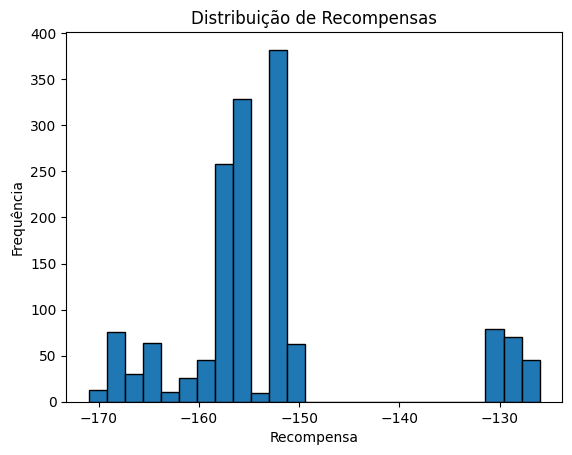


Recompensa média=-153.04 +/- 10.40
1º Quartil: -157.00
Mediana (2º Quartil): -155.00
3º Quartil: -152.00


In [26]:
# Evaluate our Agent
mean_reward, std_reward, percentiles = evaluate_agent(env, max_steps, 1500, Qtable_mountain_car)

print(f"\nRecompensa média={mean_reward:.2f} +/- {std_reward:.2f}")
print(f"1º Quartil: {percentiles[0]:.2f}")
print(f"Mediana (2º Quartil): {percentiles[1]:.2f}")
print(f"3º Quartil: {percentiles[2]:.2f}")

Uma recompensa média de -153.04 com um desvio padrão de 10.40 é um resultado que entendemos ser promissor para o desafio proposto do Mountain Car.

Nossa leitura é que o agente aprendeu uma política eficaz que faz com que ele consiga alcançar o objetivo (a bandeira) dentro do limite máximo de passos (200) após uma série de execuções, neste caso 1500 episódios.

A recompensa média negativa é esperada para o ambiente Mountain Car, uma vez que, além de cada passo ser atribuida uma recompensa -1, o agente precisa superar a gravidade e a inércia para alcançar a bandeira, o que é uma tarefa desafiadora e demanda vários passos. O desvio padrão mostra que existe alguma variabilidade nas recompensas, o que é típico para problemas de aprendizado por reforço, mas ainda assim, o agente parece ser consistente em seu desempenho.

#### Não modifique essa parte


In [27]:
def record_video(env, Qtable, out_directory, fps=1):
  """
   Gerar um vídeo de replay do agente
   :param env
   :param Qtable: Qtable do nosso agente
   :param out_directory
   :param fps: quantos quadros por segundo (com taxi-v3 e frozenlake-v1 usamos 1)
   """
  images = []
  done = False
  state = env.reset()
  img = env.render(mode='rgb_array')
  images.append(img)

  while not done:
    # Tome a ação (índice) que tem a recompensa futura máxima esperada dado aquele estado
    position, velocity = mapear_obs(state)
    action = np.argmax(Qtable[position][velocity][:])
    state, reward, done, info = env.step(action) # Colocamos diretamente next_state = state para a lógica de gravação
    img = env.render(mode='rgb_array')
    images.append(img)
  imageio.mimsave(out_directory, [np.array(img) for i, img in enumerate(images)], fps=fps)

In [28]:
video_path =  "replay.mp4"
record_video(env, Qtable_mountain_car, video_path, 2)

In [29]:
from IPython.display import HTML
from base64 import b64encode
import os


# Show video
mp4 = open(video_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)